In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
cd "/content/drive/My Drive/MachineLearningMy"
ls

/content/drive/My Drive/MachineLearningMy


In [5]:
from pathlib import Path

import numpy as np
import pandas as pd

pd.set_option("display.max_columns", 100)

DATA_PATH = Path.cwd().parent / "data" / "final" / "public"

train_df = pd.read_csv(
    DATA_PATH / "/content/drive/My Drive/MachineLearningMy/train.csv", 
    index_col="tripid"
)
test_features_df = pd.read_csv(
    DATA_PATH / "/content/drive/My Drive/MachineLearningMy/test.csv", 
    index_col="tripid"
)

labels_df = train_df[['label']]
features_df = train_df.drop('label', axis=1)

print("features_df.shape", features_df.shape)
features_df.head()

features_df.shape (17176, 12)


,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare
tripid,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32
189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85
189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64
189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30
189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39


In [0]:
labels_df=labels_df.replace("correct", 1)
labels_df=labels_df.replace("incorrect", 0)
labels_df
print("labels_df.shape", labels_df.shape)
labels_df.head()

In [9]:
features_df.dtypes

additional_fare              float64
duration                     float64
meter_waiting                float64
meter_waiting_fare           float64
meter_waiting_till_pickup    float64
pickup_time                   object
drop_time                     object
pick_lat                     float64
pick_lon                     float64
drop_lat                     float64
drop_lon                     float64
fare                         float64
dtype: object

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

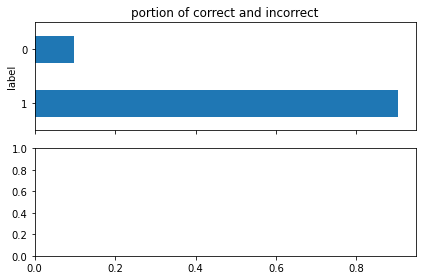

In [11]:
fig, ax = plt.subplots(2, 1, sharex=True)

n_obs = labels_df.shape[0]

(labels_df['label']
    .value_counts()
    .div(n_obs)
    .plot.barh(title="portion of correct and incorrect", ax=ax[0])
)
ax[0].set_ylabel("label")

fig.tight_layout()

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from imblearn.over_sampling import SMOTE 
from sklearn.metrics import f1_score
from sklearn.utils import resample

from sklearn.ensemble import RandomForestClassifier

RANDOM_SEED = 8    # Set a random seed for reproducibility!

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
#features_df.dtypes != "object"

additional_fare               True
duration                      True
meter_waiting                 True
meter_waiting_fare            True
meter_waiting_till_pickup     True
pickup_time                  False
drop_time                    False
pick_lat                      True
pick_lon                      True
drop_lat                      True
drop_lon                      True
fare                          True
dtype: bool

In [0]:
features_df['drop_time'] = features_df['drop_time'].astype('datetime64[m]')
features_df['pickup_time'] = features_df['pickup_time'].astype('datetime64[m]')

features_df['drop_time'] = [time.minute for time in features_df['drop_time']]
features_df['pickup_time'] = [time.minute for time in features_df['pickup_time']]

In [70]:
numeric_cols = features_df.columns[features_df.dtypes != "object"].values
print(numeric_cols)

['additional_fare' 'duration' 'meter_waiting' 'meter_waiting_fare'
 'meter_waiting_till_pickup' 'pickup_time' 'drop_time' 'pick_lat'
 'pick_lon' 'drop_lat' 'drop_lon' 'fare']


In [44]:
features_df.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare
tripid,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,64.0,20,34,6.86252,79.8993,6.90330,79.8783,270.32
189125358,10.5,791.0,47.0,0.0000,134.0,56,9,6.88589,79.8984,6.91373,79.8923,197.85
189125719,10.5,1087.0,80.0,0.0000,61.0,8,26,6.90839,79.8651,6.93669,79.9146,301.64
189127273,10.5,598.0,271.0,15.6638,68.0,27,37,6.92570,79.8895,6.92748,79.8971,82.30
189128020,NaN,NaN,NaN,NaN,NaN,34,51,6.87441,79.8615,6.84478,79.9290,358.39


In [0]:
# chain preprocessing into a Pipeline object
# each step is a tuple of (name you chose, sklearn transformer)
numeric_preprocessing_steps = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('standard_scaler', StandardScaler())])
# create the preprocessor stage of final pipeline
# each entry in the transformer list is a tuple of
# (name you choose, sklearn transformer, list of columns)
preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", numeric_preprocessing_steps, numeric_cols)
    ],
    remainder = "drop"
)

In [0]:
estimator = RandomForestClassifier(n_estimators=10000)

In [0]:
full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", estimator),
])

In [48]:
full_pipeline

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numeric',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                         

In [0]:
X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    labels_df,
    test_size=0.33,
    shuffle=True,
    stratify=labels_df,
    random_state=RANDOM_SEED
)

In [50]:
%%time

# Train model
full_pipeline.fit(X_train, y_train.values.ravel())

# Predict on evaluation set
preds = full_pipeline.predict(X_eval)
preds

CPU times: user 5min 30s, sys: 727 ms, total: 5min 31s
Wall time: 5min 31s


In [51]:
preds

array([1, 1, 1, ..., 1, 1, 1])

In [52]:
print("test_score.shape", preds.shape)

test_score.shape (5669,)


In [53]:
y_preds = pd.DataFrame(
    {
        "label": preds,
    },
    index = y_eval.index
)
print("y_preds.shape:", y_preds.shape)
y_preds.head()

y_preds.shape: (5669, 1)


,label
tripid,
200328361,1
191127057,1
200136070,1
195614910,1
191488838,1


In [54]:
f1_score(y_eval, y_preds, average='macro')

0.7907282552556638

In [55]:
%%time 

full_pipeline.fit(features_df, labels_df.values.ravel())

None   # So we don't print out the whole pipeline representation

CPU times: user 8min 13s, sys: 609 ms, total: 8min 14s
Wall time: 8min 14s


In [0]:


test_features_df['drop_time'] = test_features_df['drop_time'].astype('datetime64[m]')
test_features_df['pickup_time'] = test_features_df['pickup_time'].astype('datetime64[m]')

test_features_df['drop_time'] = [time.minute for time in test_features_df['drop_time']]
test_features_df['pickup_time'] = [time.minute for time in test_features_df['pickup_time']]


In [59]:
test_features_df.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare
tripid,,,,,,,,,,,,
213284604,10.5,924,42,2.4486,148,38,53,6.83454,79.8750,6.77490,79.8840,289.27
213286352,10.5,4249,20,0.0000,91,2,13,6.91168,79.8723,6.55091,79.9706,1912.70
213293973,10.5,1552,255,2.6588,23,2,28,6.92145,79.8478,6.90539,79.8989,394.00
213294622,10.5,462,16,0.0000,198,30,38,6.77433,79.9416,6.80401,79.9407,154.32
213298687,10.5,814,392,12.3692,69,0,14,6.97968,79.9130,6.98875,79.8914,147.47


In [56]:
#test_features_df.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare
tripid,,,,,,,,,,,,
213284604,10.5,924,42,2.4486,148,2/1/2020 0:38,2/1/2020 0:53,6.83454,79.8750,6.77490,79.8840,289.27
213286352,10.5,4249,20,0.0000,91,2/1/2020 1:02,2/1/2020 2:13,6.91168,79.8723,6.55091,79.9706,1912.70
213293973,10.5,1552,255,2.6588,23,2/1/2020 5:02,2/1/2020 5:28,6.92145,79.8478,6.90539,79.8989,394.00
213294622,10.5,462,16,0.0000,198,2/1/2020 5:30,2/1/2020 5:38,6.77433,79.9416,6.80401,79.9407,154.32
213298687,10.5,814,392,12.3692,69,2/1/2020 7:00,2/1/2020 7:14,6.97968,79.9130,6.98875,79.8914,147.47


In [60]:
test_score1 = full_pipeline.predict(test_features_df)
test_score1

array([1, 1, 1, ..., 1, 1, 1])

In [61]:
test_score1.shape

(8576,)

In [0]:
# test_score1[test_score1 == "correct"] = 1
# test_score1[test_score1 == "incorrect"] = 0
# test_score1

In [62]:
y_preds1 = pd.DataFrame(
    {
        # "label": test_score1[:,0],
        "label": test_score1,
    },
    index = test_features_df.index
)
print("y_preds1.shape:", y_preds1.shape)
y_preds1.head()

y_preds1.shape: (8576, 1)


,label
tripid,
213284604,1
213286352,1
213293973,1
213294622,1
213298687,1


In [0]:
submission_df = pd.read_csv(DATA_PATH / "/content/drive/My Drive/MachineLearningMy/sample_submission.csv", 
                            index_col="tripid")

In [64]:
submission_df.head()

,prediction
tripid,
213284604,1
213286352,0
213293973,0
213294622,1
213298687,1


In [0]:
# Make sure we have the rows in the same order
np.testing.assert_array_equal(test_features_df.index.values, 
                              submission_df.index.values)

In [66]:
# Save predictions to submission data frame
submission_df["prediction"] = test_score1

submission_df.head()

,prediction
tripid,
213284604,1
213286352,1
213293973,1
213294622,1
213298687,1


In [0]:
submission_df.to_csv('my_submission3.csv', index=True)

In [68]:
!head my_submission3.csv

tripid,prediction
213284604,1
213286352,1
213293973,1
213294622,1
213298687,1
213299545,1
213302332,1
213302671,1
213305594,1


In [0]:
# X_train.label
# dfs = np.split(X_train, [12], axis=1)
# X_train_features=dfs[0]
# y_train_labels=dfs[1]

In [0]:
# X_eval.label
# dfs = np.split(X_eval, [12], axis=1)
# X_eval_features=dfs[0]
# y_eval_labels=dfs[1]